<a href="https://colab.research.google.com/github/otrilas/IA/blob/main/Sensio_Ex_Ej_1_2par.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/024_mlp_clasificacion/mlp_clasificacion.ipynb)

# El Perceptrón Multicapa - Clasificación

## El Perceptrón Multicapa

En el [post](https://sensioai.com/blog/023_mlp_backprop) anterior hemos introducido el modelo de `Perceptrón Multicapa`, o MLP, la arquitectura de red neuronal más básica basada en el [Perceptrón](https://sensioai.com/blog/012_perceptron1). Hemos visto cómo calcular la salida de un MLP de dos capas a partir de unas entradas y cómo encontrar los pesos óptimos para una tarea de regresión. En este post vamos a mejorar la implementación de nuestro MLP de dos capas para que sea capaz también de llevar a cabo tareas de clasificación.

![](https://www.researchgate.net/profile/Mohamed_Zahran6/publication/303875065/figure/fig4/AS:371118507610123@1465492955561/A-hypothetical-example-of-Multilayer-Perceptron-Network.png)

## Implementación

La mayoría del código que utilizaremos fue desarrollado para el `Perceptrón` y lo puedes encontrar en este [post](https://sensioai.com/blog/018_perceptron_final). Lo único que cambiaremos es la lógica del modelo, el resto de funcionalidad (funciones de pérdida, funciones de activación, etc, siguen siendo exactamente igual).

### Funciones de activación

Para la capa oculta de nuestro MLP utilizaremos una función de activación de tipo `relu`, de la cual necesitaremos su derivada.

In [1]:
def relu(x):
  return np.maximum(0, x)

def reluPrime(x):
  return x > 0

En cuanto a las funciones de activación que utilizaremos a la salida del MLP, éstas son las que hemos introducido en posts anteriores:

- Lineal: usada para regresión (junto a la función de pérdida MSE).
- Sigmoid: usada para clasificación binaria (junto a la función de pérdida BCE).
- Softmax: usada para clasificación multiclase (junto a la función de pérdida crossentropy, CE).

In [2]:
def linear(x):
    return x

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def softmax(x):
    return np.exp(x) / np.exp(x).sum(axis=-1,keepdims=True)

### Funciones de pérdida

Como acabamos de comentar en la sección anterior, estas son las funciones de pérdida que hemos visto hasta ahora para las diferentes tareas.

In [3]:
# Mean Square Error -> usada para regresión (con activación lineal)
def mse(y, y_hat):
    return np.mean((y_hat - y.reshape(y_hat.shape))**2)

# Binary Cross Entropy -> usada para clasificación binaria (con sigmoid)
def bce(y, y_hat):
    return - np.mean(y.reshape(y_hat.shape)*np.log(y_hat) - (1 - y.reshape(y_hat.shape))*np.log(1 - y_hat))

# Cross Entropy (aplica softmax + cross entropy de manera estable) -> usada para clasificación multiclase
def crossentropy(y, y_hat):
    logits = y_hat[np.arange(len(y_hat)),y]
    entropy = - logits + np.log(np.sum(np.exp(y_hat),axis=-1))
    return entropy.mean()

Y sus derivadas

In [4]:
def grad_mse(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_bce(y, y_hat):
    return y_hat - y.reshape(y_hat.shape)

def grad_crossentropy(y, y_hat):
    answers = np.zeros_like(y_hat)
    answers[np.arange(len(y_hat)),y] = 1    
    return (- answers + softmax(y_hat)) / y_hat.shape[0]

### Implementación MLP

Ahora que ya tenemos definidas las diferentes funciones de activación y de pérdida que necesitamos, vamos a implementar nuestro MLP de dos capas capaz de llevar a cabo tanto tareas de regresión como de clasificación. Del mismo modo que ya hicimos con el `Perceptrón`, definiremos una clase base que servirá para la implementación de las clases particulares para cada caso.

In [5]:
# clase base MLP 

class MLP():
  def __init__(self, D_in, H, D_out, loss, grad_loss, activation):
    # pesos de la capa 1
    self.w1, self.b1 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(D_in+H)),
                                  size=(D_in, H)), np.zeros(H)
    # pesos de la capa 2
    self.w2, self.b2 = np.random.normal(loc=0.0,
                                  scale=np.sqrt(2/(H+D_out)),
                                  size=(H, D_out)), np.zeros(D_out)
    self.ws = []
    # función de pérdida y derivada
    self.loss = loss
    self.grad_loss = grad_loss
    # función de activación
    self.activation = activation

  def __call__(self, x):
    # salida de la capa 1
    self.h_pre = np.dot(x, self.w1) + self.b1
    self.h = relu(self.h_pre)
    # salida del MLP
    y_hat = np.dot(self.h, self.w2) + self.b2 
    return self.activation(y_hat)
    
  def fit(self, X, Y, epochs = 10000000, lr = 0.00001, batch_size=None, verbose=True, log_each=1):
    batch_size = len(X) if batch_size == None else batch_size
    batches = len(X) // batch_size
    l = []
    for e in range(1,epochs+1):     
        # Mini-Batch Gradient Descent
        _l = []
        for b in range(batches):
            # batch de datos
            x = X[b*batch_size:(b+1)*batch_size]
            y = Y[b*batch_size:(b+1)*batch_size] 
            # salida del perceptrón
            y_pred = self(x) 
            # función de pérdida
            loss = self.loss(y, y_pred)
            _l.append(loss)        
            # Backprop 
            dldy = self.grad_loss(y, y_pred) 
            grad_w2 = np.dot(self.h.T, dldy)
            grad_b2 = dldy.mean(axis=0)
            dldh = np.dot(dldy, self.w2.T)*reluPrime(self.h_pre)      
            grad_w1 = np.dot(x.T, dldh)
            grad_b1 = dldh.mean(axis=0)
            # Update (GD)
            self.w1 = self.w1 - lr * grad_w1
            self.b1 = self.b1 - lr * grad_b1
            self.w2 = self.w2 - lr * grad_w2
            self.b2 = self.b2 - lr * grad_b2
        l.append(np.mean(_l))
        # guardamos pesos intermedios para visualización
        self.ws.append((
            self.w1.copy(),
            self.b1.copy(),
            self.w2.copy(),
            self.b2.copy()
        ))
        if verbose and not e % log_each:
            print(f'Epoch: {e}/{epochs}, Loss: {np.mean(l):.5f}')

  def predict(self, ws, x):
    w1, b1, w2, b2 = ws
    h = relu(np.dot(x, w1) + b1)
    y_hat = np.dot(h, w2) + b2
    return self.activation(y_hat)

In [6]:
# MLP para regresión
class MLPRegression(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, mse, grad_mse, linear)

# MLP para clasificación binaria
class MLPBinaryClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, bce, grad_bce, sigmoid)

# MLP para clasificación multiclase
class MLPClassification(MLP):
    def __init__(self, D_in, H, D_out):
        super().__init__(D_in, H, D_out, crossentropy, grad_crossentropy, linear)

Vamos a probar ahora nuestra implementación para diferentes ejemplos.

## Regresión

En primer lugar, vamos a replicar los resultados obtenidos en el post anterior para verificar que nuestro modelo de MLP sigue funcionando bien.

In [7]:
# utilizado para manejos de directorios y rutas
import os

# Computacion vectorial y cientifica para python
import numpy as np
import pandas as pd
# Librerias para graficación (trazado de gráficos)
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # Necesario para graficar superficies 3D
import matplotlib.pyplot as plt
# llama a matplotlib a embeber graficas dentro de los cuadernillos
%matplotlib inline

In [8]:
# Leer datos separados por una coma
data = np.loadtxt(os.path.join('DATASET.csv'), delimiter=',')
X, y = data[:,: 7], data[:,7]
m = y.size
print(f'datos x: {X}')
print(f'datos y: {y}')
print(X.shape)
print(y.shape)

datos x: [[2.000e+00 2.011e+03 2.000e+00 ... 2.000e+00 1.000e+00 2.000e+00]
 [2.000e+00 2.016e+03 3.000e+00 ... 1.000e+00 1.000e+00 2.000e+00]
 [2.000e+00 2.016e+03 2.000e+00 ... 1.000e+00 1.000e+00 2.000e+00]
 ...
 [1.700e+01 2.001e+03 2.000e+00 ... 2.000e+00 1.000e+00 2.000e+00]
 [1.200e+01 1.985e+03 1.000e+00 ... 1.000e+00 1.000e+00 2.000e+00]
 [1.200e+01 1.985e+03 1.000e+00 ... 2.000e+00 1.000e+00 2.000e+00]]
datos y: [ 99856. 977011. 977011. ...   2001.   2000.   2000.]
(1161, 7)
(1161,)


In [9]:
def  normalizacion(X):
    X_norm = X.copy()
    mu = np.zeros(X.shape[1])
    sigma = np.zeros(X.shape[1])

    mu = np.mean(X, axis = 0)
    sigma = np.std(X, axis = 0)
    X_norm = (X - mu) / sigma
    
    return X_norm, mu, sigma

In [10]:
X_norm, mu, sigma = normalizacion(X)
X_norm

array([[-1.27462736, -0.08822311,  0.09637895, ...,  1.14575259,
        -0.25994598,  0.40845339],
       [-1.27462736,  0.58830943,  1.32600486, ..., -0.87278877,
        -0.25994598,  0.40845339],
       [-1.27462736,  0.58830943,  0.09637895, ..., -0.87278877,
        -0.25994598,  0.40845339],
       ...,
       [ 0.6268319 , -1.44128817,  0.09637895, ...,  1.14575259,
        -0.25994598,  0.40845339],
       [-0.00698785, -3.60619227, -1.13324697, ..., -0.87278877,
        -0.25994598,  0.40845339],
       [-0.00698785, -3.60619227, -1.13324697, ...,  1.14575259,
        -0.25994598,  0.40845339]])

In [11]:
X = np.array(X_norm)
y = np.array(y)

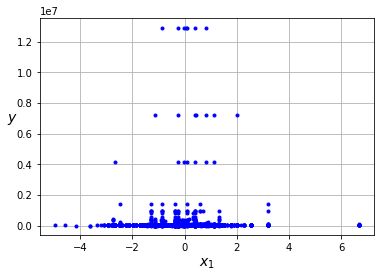

In [12]:
plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [13]:
print(X.shape)
print(y.shape)

(1161, 7)
(1161,)


In [17]:

#Regrecion lineal Ajustando a una linea
model = MLPRegression(D_in=1, H=3, D_out=1)
epochs, lr = 50000, 0.001
model.fit(X.reshape(len(X),7), y, epochs, lr, log_each=100)


ValueError: ignored

In [ ]:
x_new = np.linspace(0, 12, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = model(x_new)
    
plt.plot(X, y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

In [20]:
X_ = np.array(X_norm)
y_ = np.array(y)
print(X_.shape)
print(y_.shape)

(1161, 7)
(1161,)


In [21]:
#Redes neuronales con multiples neuronas
model1 = MLPRegression(D_in=1, H=3, D_out=1)
epochs1, lr1 = 50000, 0.001
model1.fit(X_.reshape(len(X_),7), y, epochs1, lr1, batch_size=3, log_each=10)

ValueError: ignored

In [ ]:
x_new = np.linspace(0, 12, 100)
x_new = x_new.reshape(len(x_new),1)
y_pred = model(x_new)
    
plt.plot(X, y, "b.")
plt.plot(x_new, y_pred, "-k")
plt.xlabel("$x_1$", fontsize=14)
plt.ylabel("$y$", rotation=0, fontsize=14)
plt.grid(True)
plt.show()

Como puedes observar nuestro MLP es capaz de ajustarse a datos que no sigan una distribución lineal. Ésta es la principal limitación del `Perceptrón`, es un modelo muy simple, y el MLP es capaz de solventar este problema (siempre y cuando usemos funciones de activación no lineales en la capa oculta. ¿Sabes por qué? Puedes encontrar la respuesta en el [post](https://sensioai.com/blog/023_mlp_backprop) anterior).

## Resumen

En este post hemos visto como implementar un `Perceptrón Multicapa` en `Python` para tareas de regresión y clasificación. Como ya hicimos anteriormente para el caso del `Perceptrón` hemos validado nuestra implementación con el dataset de clasificación de flores *Iris*, tanto para clasificación binaria como multiclase. Sin embargo, nuestra implementación está muy limitada. ¿Qué pasa si queremos usar un MLP de más de dos capas?, ¿y si queremos usar una función de activación diferente a la `relu` en la capa oculta?, ¿podríamos utilizar un algoritmo de optimizaciñon diferente al `descenso por gradiente`? Para poder hacer todo esto necesitamos un `framework` más flexible, similar a lo que nos ofrecen `Pytorch` y `Tensorflow`. En el siguiente post desarrollaremos nuestro propio framework de MLP para que sea más flexible y que también nos servirá para entender cómo funcionan el resto de frameworks de `redes neuronales` por dentro.